## Gender classification based on audio recordings

### 1 Web-Scrape . Batch download all compressed files containing the audio recordings

The dataset consisting on 62,440 audio samples compressed (tgz) in sets of 10 files was automatically downloaded from the url 
http://www.repository.voxforge1.org/downloads/SpeechCorpus/Trunk/Audio/Main/16kHz_16bit

The Python package Beautiful Soup for parsing HTML and XML documents makes this task easy and straight forward.

Below there is a sample of the key lines of the code to extract the links to the compressed files and download them.                                
But the file **scrape.py** can be run to do the task. It will create a raw/ folder in the current directory and download all .tgz files into it

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import shutil
import os

URL = "http://www.repository.voxforge1.org/downloads/SpeechCorpus/Trunk/Audio/Main/16kHz_16bit/"

def download_file(from_url, local_path):
    r = requests.get(from_url, stream=True)
    with open(local_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

def batch_download(matches):
    for match in matches:
        file_url = os.path.join(URL, match['href'])
        file_local = os.path.join('raw', match['href'])
        download_file(file_url, file_local)

response = requests.get(URL)
soup = BeautifulSoup(response.text, 'html.parser')
matches = soup.find_all('a', attrs={"href": re.compile("tgz")})

# Note: Don't run this here in the notebook. This is just for illustration purpose
#batch_download(matches) 

### 2 Unzip compressed audio files

Uncompress the tgz files using the Python library tarfile                                 
This, together with number 1 (the downloading part) only needs to be done once, at first. 
This is just illustrative.                                 
The file **unzipper.py** can be run to do this.                                

In [6]:
import os
import tarfile

raw_folder = './raw/'

#don't run this in the notebook

#for f in os.listdir(raw_folder):
#    if f.endswith('.tgz'):
#        tar = tarfile.open(os.path.join(raw_folder, f))
#        tar.extractall(raw_folder) #dont run in notebook
#        tar.close()


### 3 Feature extraction

Now comes the interesting part.  

First the contents of every wave file are read, then the features are extracted and saved into a pandas dataframe.    

In addition to the wave file, the README files are also parsed to extract metadata: gender, age range and pronunciation                                 

Notably, the python package **Scipy wavfile** is used to get the audio data, **Scipy stats** to extract the main features and **Numpy** and its fast fourier transform **fft** and **fftfreq** to extrapolate the wav data to frequencies   

Again the feature extraction (including the steps below here) can be run independently using **featureExtractor.py**  

The data from the wav files is recorded as amplitude in the time domain, but the potentially interesting features (with a higher discriminative power male/female) are frequencies. To convert the data to frequencies we use DFT (Discrete Fourier Transforms), particularly the FFT implementation (Fast Fourier Transform) of the algorithm . 

The Fourier transform takes a signal in the time domain (set of measurements over time) and turns it into a spectrum - a set of frequencies with corresponding (complex) values. The spectrum does not contain any information about time!  

So, to find both the frequencies and the time at which they were recorded, the audio signal is split into small, overlapping slices, and the Fourier transform  is applied to each (short time Fourier transform).

np.fft.fft returns a complex spectrum 

np.fft.fftfreq returns the sample frequencies

A sample folder consists of 10 audio recordings from one particular user.  

Every wav file in the folder is processed in a way that the dominanting frequencies in sliding windows of 200ms (1/5th of a second) are extracted. If a wav file is 4 seconds long, a list containing 20 frequencies will be extracted.  
For the sample folder (user), 10 lists corresponding to the 10 wav files (containing 20 frequencies each) will be collected in a list of lists.  

The list of frequencies is then filtered to contain only values in the human voice range (20Hz < frequency < 280Hz)
In addition, values around 50Hz are most likely noise and also filtered (https://en.wikipedia.org/wiki/Mains_hum) 

In [7]:
import pandas as pd
import re
import scipy.stats as stats
from scipy.io import wavfile
import numpy as np
import os

Define the path to the folder where all the uncompressed sample folders are

In [8]:
raw_folder = './raw/'

Get a list with the names of the uncompressed folders that contain the audio files

In [9]:
samples = [d for d in os.listdir(raw_folder) if os.path.isdir(os.path.join(raw_folder, d))]
n_samples = len(samples)

Create an empty pandas dataframe that will contain the features

In [10]:
columns=['nobs', 'mean', 'skew', 'kurtosis', 'median', 'mode', 'std', 'low', 'peak', 'q25', 'q75', 'iqr', 
 'user_name', 'sample_date', 'age_range', 'pronunciation', 'gender']

myData = pd.DataFrame(columns=columns)

Define some regular expressions to homogenize the different used formats

In [11]:
pattern_date = re.compile('[0-9]{8}')

female_pattern = re.compile('[Ff]emale')
male_pattern = re.compile('[Mm]ale')

american_pattern = re.compile('[Aa]merican')
british_pattern = re.compile('[Bb]ritish')
european_pattern = re.compile('[Ee]uropean')
indian_pattern = re.compile('[Ii]ndian')
australian_pattern = re.compile('[Aa]ustralian')

adult_pattern = re.compile('[Aa]dult')
youth_pattern = re.compile('[Yy]outh')
senior_pattern = re.compile('[Ss]enior')

#### Define some functions that we will use to extract the metadata and more importantly the features from the wav files

In [12]:
def get_metadata(readme_file):

    #define variables in case startswith does not work:
    gender, age_range, pronunciation = 'not specified', 'not specified', 'not specified' 
    for line in open(readme_file):
        if line.startswith("Gender:"): 
            gender = line.split(":")[1].strip()
        elif line.startswith("Age Range:"): 
            age_range = line.split(":")[1].strip()
        elif line.startswith("Pronunciation dialect:"): 
            pronunciation = line.split(":")[1].strip()
    return gender, age_range, pronunciation

In [13]:
def get_features(frequencies):

    print "\nExtracting features "
    nobs, minmax, mean, variance, skew, kurtosis = stats.describe(frequencies)
    median    = np.median(frequencies)
    mode      = stats.mode(frequencies).mode[0]
    std       = np.std(frequencies)
    low,peak  = minmax
    q75,q25   = np.percentile(frequencies, [75 ,25])
    iqr       = q75 - q25
    return nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr

In [14]:
def get_date(sample_name):

    try:
        date = pattern_date.search(sample_name).group()
    except AttributeError:
        date = '20000000'
    return date

In [15]:
def get_user_name(sample_name):

    return re.compile("[-_]").split(sample_name)[0]

In [16]:
def homogenize_format(gender, age_range, pronunciation):

    #Homogenize gender format
    if female_pattern.search(gender): gender = 'Female' 
    elif male_pattern.search(gender): gender = 'Male'
    else: gender = 'not_specified'

    #Homogenize pronunciation format to 5/6 categories
    if british_pattern.search(pronunciation)     : pronunciation = 'British' 
    elif american_pattern.search(pronunciation)  : pronunciation = 'American'
    elif european_pattern.search(pronunciation)  : pronunciation = 'European'
    elif indian_pattern.search(pronunciation)    : pronunciation = 'Indian'
    elif australian_pattern.search(pronunciation): pronunciation = 'Australian'
    else: pronunciation = 'Other'

    #Homogenize age range format
    if adult_pattern.search(age_range)   : age_range = 'Adult' 
    elif youth_pattern.search(age_range) : age_range = 'Youth'
    elif senior_pattern.search(age_range): age_range = 'Senior'
    else: age_range = 'Unknown'

    return gender, age_range, pronunciation

In [17]:
def get_frequencies(sample_wav_folder):
    '''
    extract list of dominant frequencies in sliding windows of duration defined by 'step' for each of the 10 wav files and return an array
    frequencies_lol: list of lists
    every item in this list will contain 10 lists corresponding to each of the 10 wav files in every sample
    and the lists within the list will contain a range of *filtered* frequencies corresponding to sliding windows within each wav file
    '''
    frequencies_lol = [] 
    for wav_file in os.listdir(sample_wav_folder):
        rate, data = wavfile.read(os.path.join(sample_wav_folder, wav_file))

        #get dominating frequencies in sliding windows of 200ms
        step = rate/5 #3200 sampling points every 1/5 sec 
        window_frequencies = []
        for i in range(0,len(data),step):
            ft = np.fft.fft(data[i:i+step])
            freqs = np.fft.fftfreq(len(ft)) #fftq tells you the frequencies associated with the coefficients
            imax = np.argmax(np.abs(ft))
            freq = freqs[imax]
            freq_in_hz = abs(freq *rate)
            window_frequencies.append(freq_in_hz)
            filtered_frequencies = [f for f in window_frequencies if 20<f<300 and not 46<f<66] 
            # I see noise at 50Hz and 60Hz. See plots below
       
        frequencies_lol.append(filtered_frequencies)

    frequencies = [item for sublist in frequencies_lol for item in sublist]

    return frequencies

#### And now iterate over the samples (folders) and look into the wav folder within them to read the wav files

In [ ]:
for i in range(n_samples):
        
    #get the path to the wav files (.raw/wav) and to the README file (.raw/etc/README)
    sample = sorted(samples)[i]
    sample_folder = os.path.join(raw_folder, sample)
    sample_wav_folder = os.path.join(sample_folder, 'wav')
    readme_file = os.path.join(sample_folder, 'etc', 'README')

    #get the information from the readme file: gender, age_range, pronunciation
    date = get_date(sample)
    user_name = get_user_name(sample)
     if os.path.isfile(readme_file):
            gender, age_range, pronunciation = get_metadata(readme_file)
    gender, age_range, pronunciation = homogenize_format(gender, age_range, pronunciation)
        
    #Read and extract the information from the wav files:        
    if os.path.isdir(sample_wav_folder): #some of the samples don't contain a wav folder (Ex: 'LunaTick-20080329-vf1')
        frequencies = get_frequencies(sample_wav_folder)
        if len(frequencies) > 10: 
            #for some of the files (ex: Aaron-20130527-giy) 
            #I only recover frequencies of 0.0 (even if I don't split in chunks) which is not integrated into my lol and frequencies is empty
            nobs, mean, skew, kurtosis, median, mode, std, low, peak, q25, q75, iqr = get_features(frequencies)
            sample_dict = {'nobs':nobs, 'mean':mean, 'skew':skew, 'kurtosis':kurtosis,
                           'median':median, 'mode':mode, 'std':std, 'low': low,
                           'peak':peak, 'q25':q25, 'q75':q75, 'iqr':iqr, 
                           'user_name':user_name, 'sample_date':date, 
                           'age_range':age_range, 'pronunciation':pronunciation,
                           'gender':gender}
            print "\nappending %s sample %s : %s"%(gender, sample, sample_dict)

            #Save to my pandas dataframe
            myData.loc[i] = pd.Series(sample_dict)
        
    #and store it to a file
    myData.to_csv('myData_filtered.csv')


### 4 Plot individual wav files 

The code for this plots is also in **sample_plots.py**

In [18]:
import matplotlib.pyplot as plt
import seaborn as sb 
sb.set_style("whitegrid", {'axes.grid' : False})

In [19]:
wav_file = '/home/vitalv/voice-gender-classifier/raw/chris-20090325-esw/wav/a0060.wav'#Noise at 50Hz #check plot_frequency
#wav_file = '/home/vitalv/voice-gender-classifier/raw/anonymous-20100621-cdr/wav/a0166.wav'
rate, data = wavfile.read(wav_file)

#### Amplitude vs Time

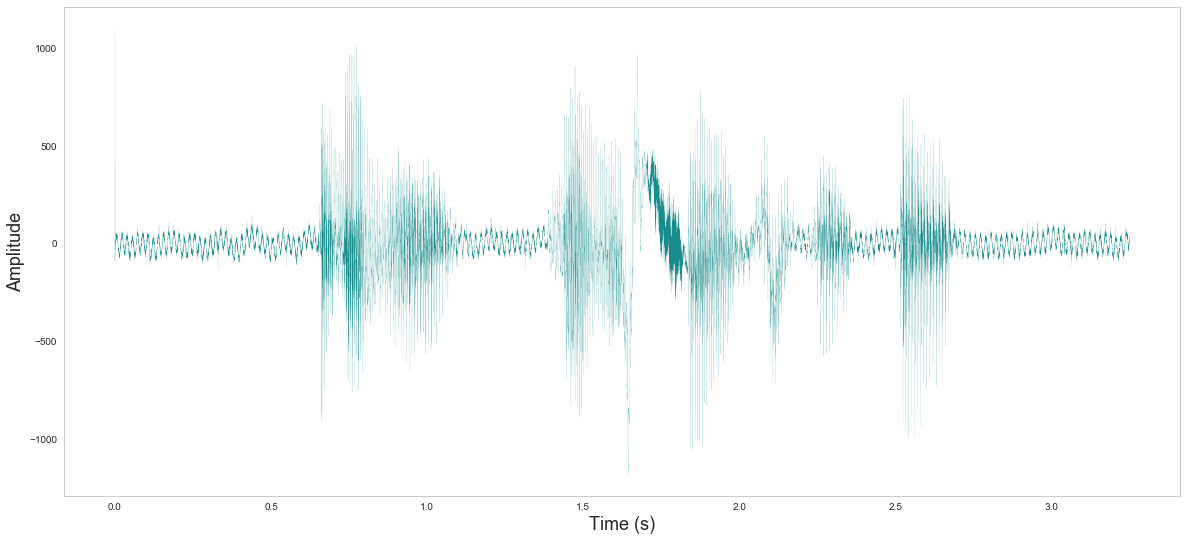

In [20]:
time = np.arange(0, float(data.shape[0]), 1) / rate
plt.figure(1, figsize=(20,9))
plt.subplot(111)
plt.plot(time, data, linewidth=0.1, alpha=0.9, color='teal') #
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
plt.show()


#### Frequency

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


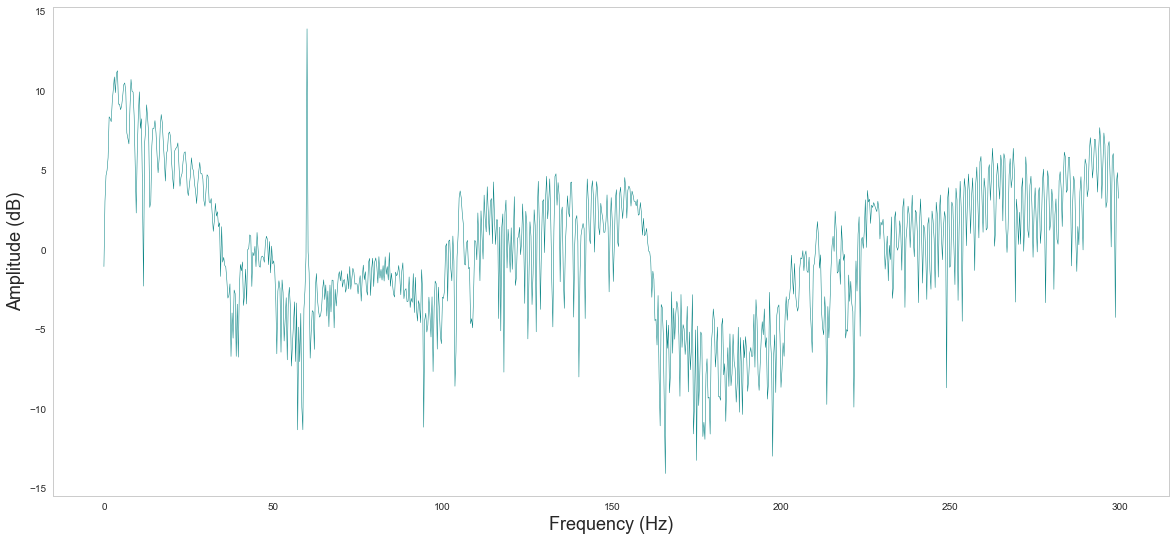

In [21]:
fourier = np.fft.fft(data)

n = len(data)
fourier = fourier[0:(n/2)]
# scale by the number of points so that the magnitude does not depend on the length
fourier = fourier / float(n)
#calculate the frequency at each point in Hz
freqArray = np.arange(0, (n/2), 1.0) * (rate*1.0/n);
x = freqArray[freqArray<300] #human voice range
y = 10*np.log10(fourier)[0:len(x)]
plt.figure(1,figsize=(20,9))
plt.plot(x, y, color='teal', linewidth=0.5)
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.ylabel('Amplitude (dB)', fontsize=18)
plt.show()

Note the spike at 52 Hz. Present in many samples. Most likely noise

#### And Heatmap

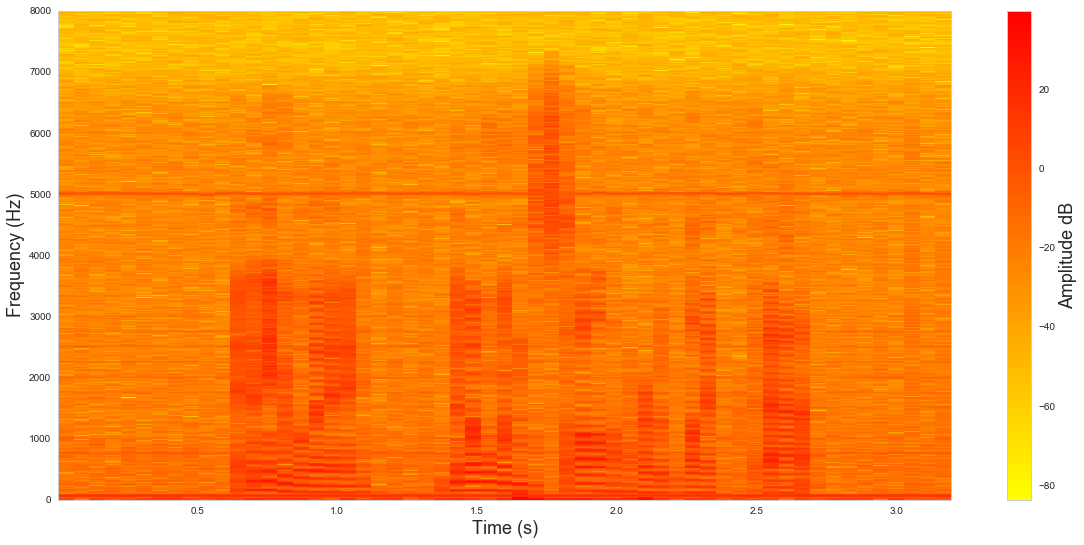

In [22]:
# See http://myinspirationinformation.com/uncategorized/audio-signals-in-python/

plt.figure(1,figsize=(20,9))
plt.subplot(111)
Pxx, freqs, bins, im = plt.specgram(data, Fs=rate, NFFT=1024, cmap=plt.get_cmap('autumn_r'))
cbar=plt.colorbar(im)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Frequency (Hz)', fontsize=18)
cbar.set_label('Amplitude dB', fontsize=18)
plt.show()

### 5 Classification models

Bunch of sklearn imports. Rest of modules have already been imported, but import them anyway so this part can be run independently

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid", {'axes.grid' : False})
sb.set(font_scale = 2)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier 

Read dataframe that I saved in step 3 (feature extraction)

In [8]:
mydata = pd.read_csv('myData_filtered.csv')

#### Basic barplots on number of male/female; pronunciation types; age_ranges

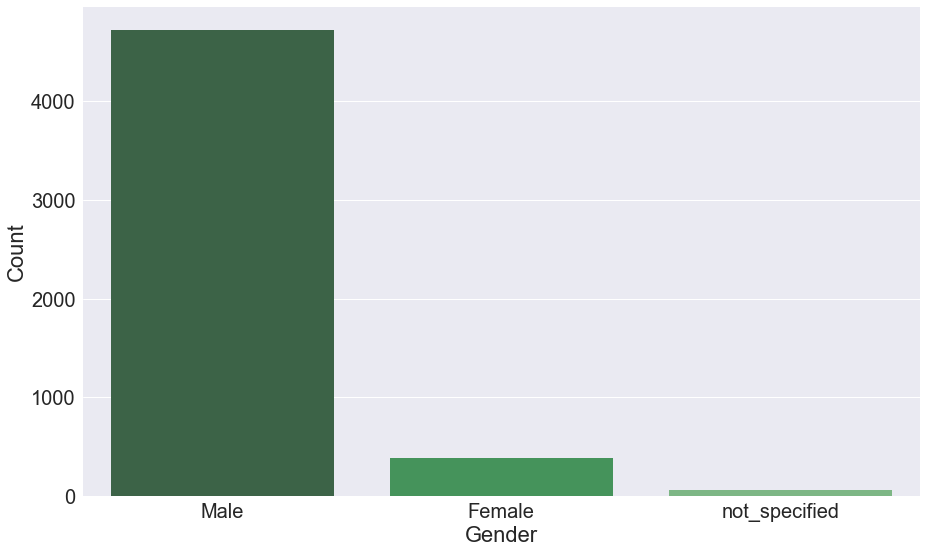

In [9]:
plt.figure(1,figsize=(15,9))
sb.countplot(x='gender', data=mydata, palette='Greens_d')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

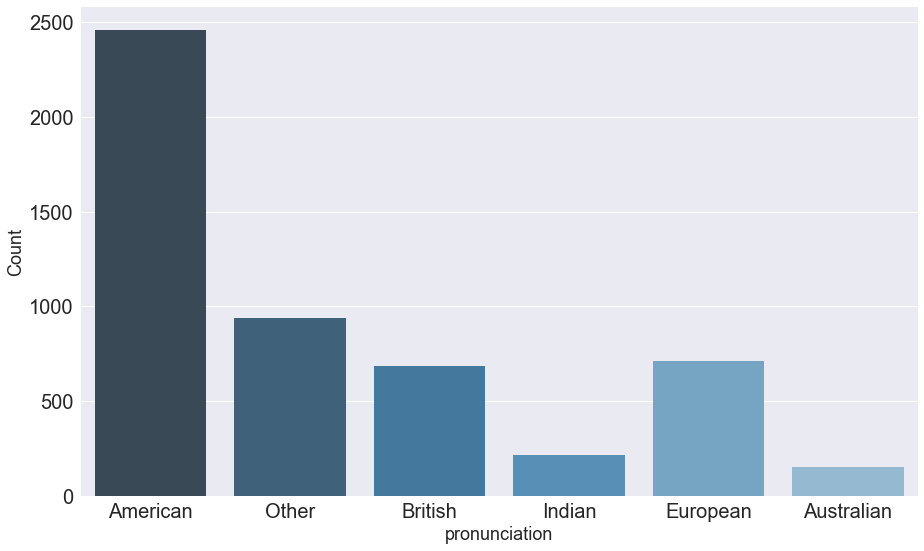

In [10]:
plt.figure(1,figsize=(15,9))
sb.countplot(x='pronunciation', data=mydata, palette='Blues_d')
plt.xlabel('pronunciation', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()

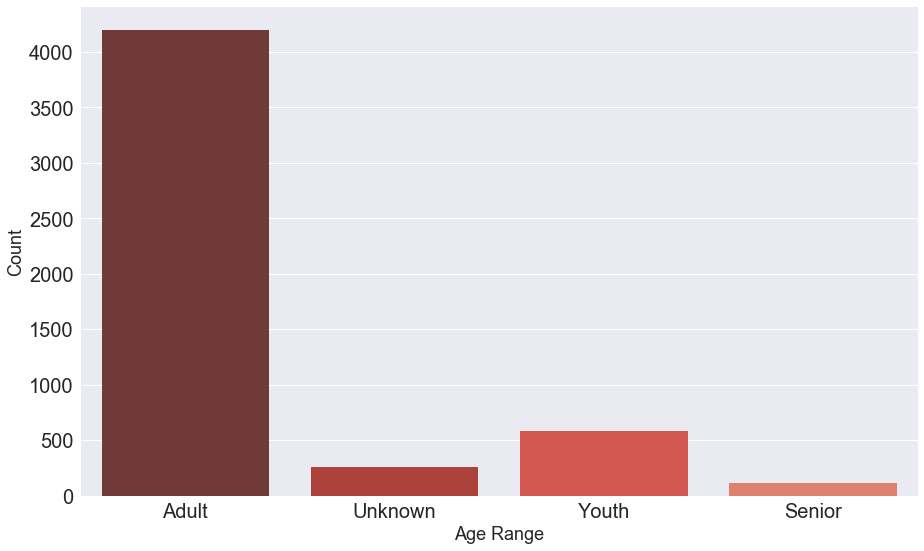

In [11]:
plt.figure(1,figsize=(15,9))
sb.countplot(x='age_range', data=mydata, palette='Reds_d')
plt.xlabel('Age Range', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.show()

### Features Distribution on the split (male/female) dataset

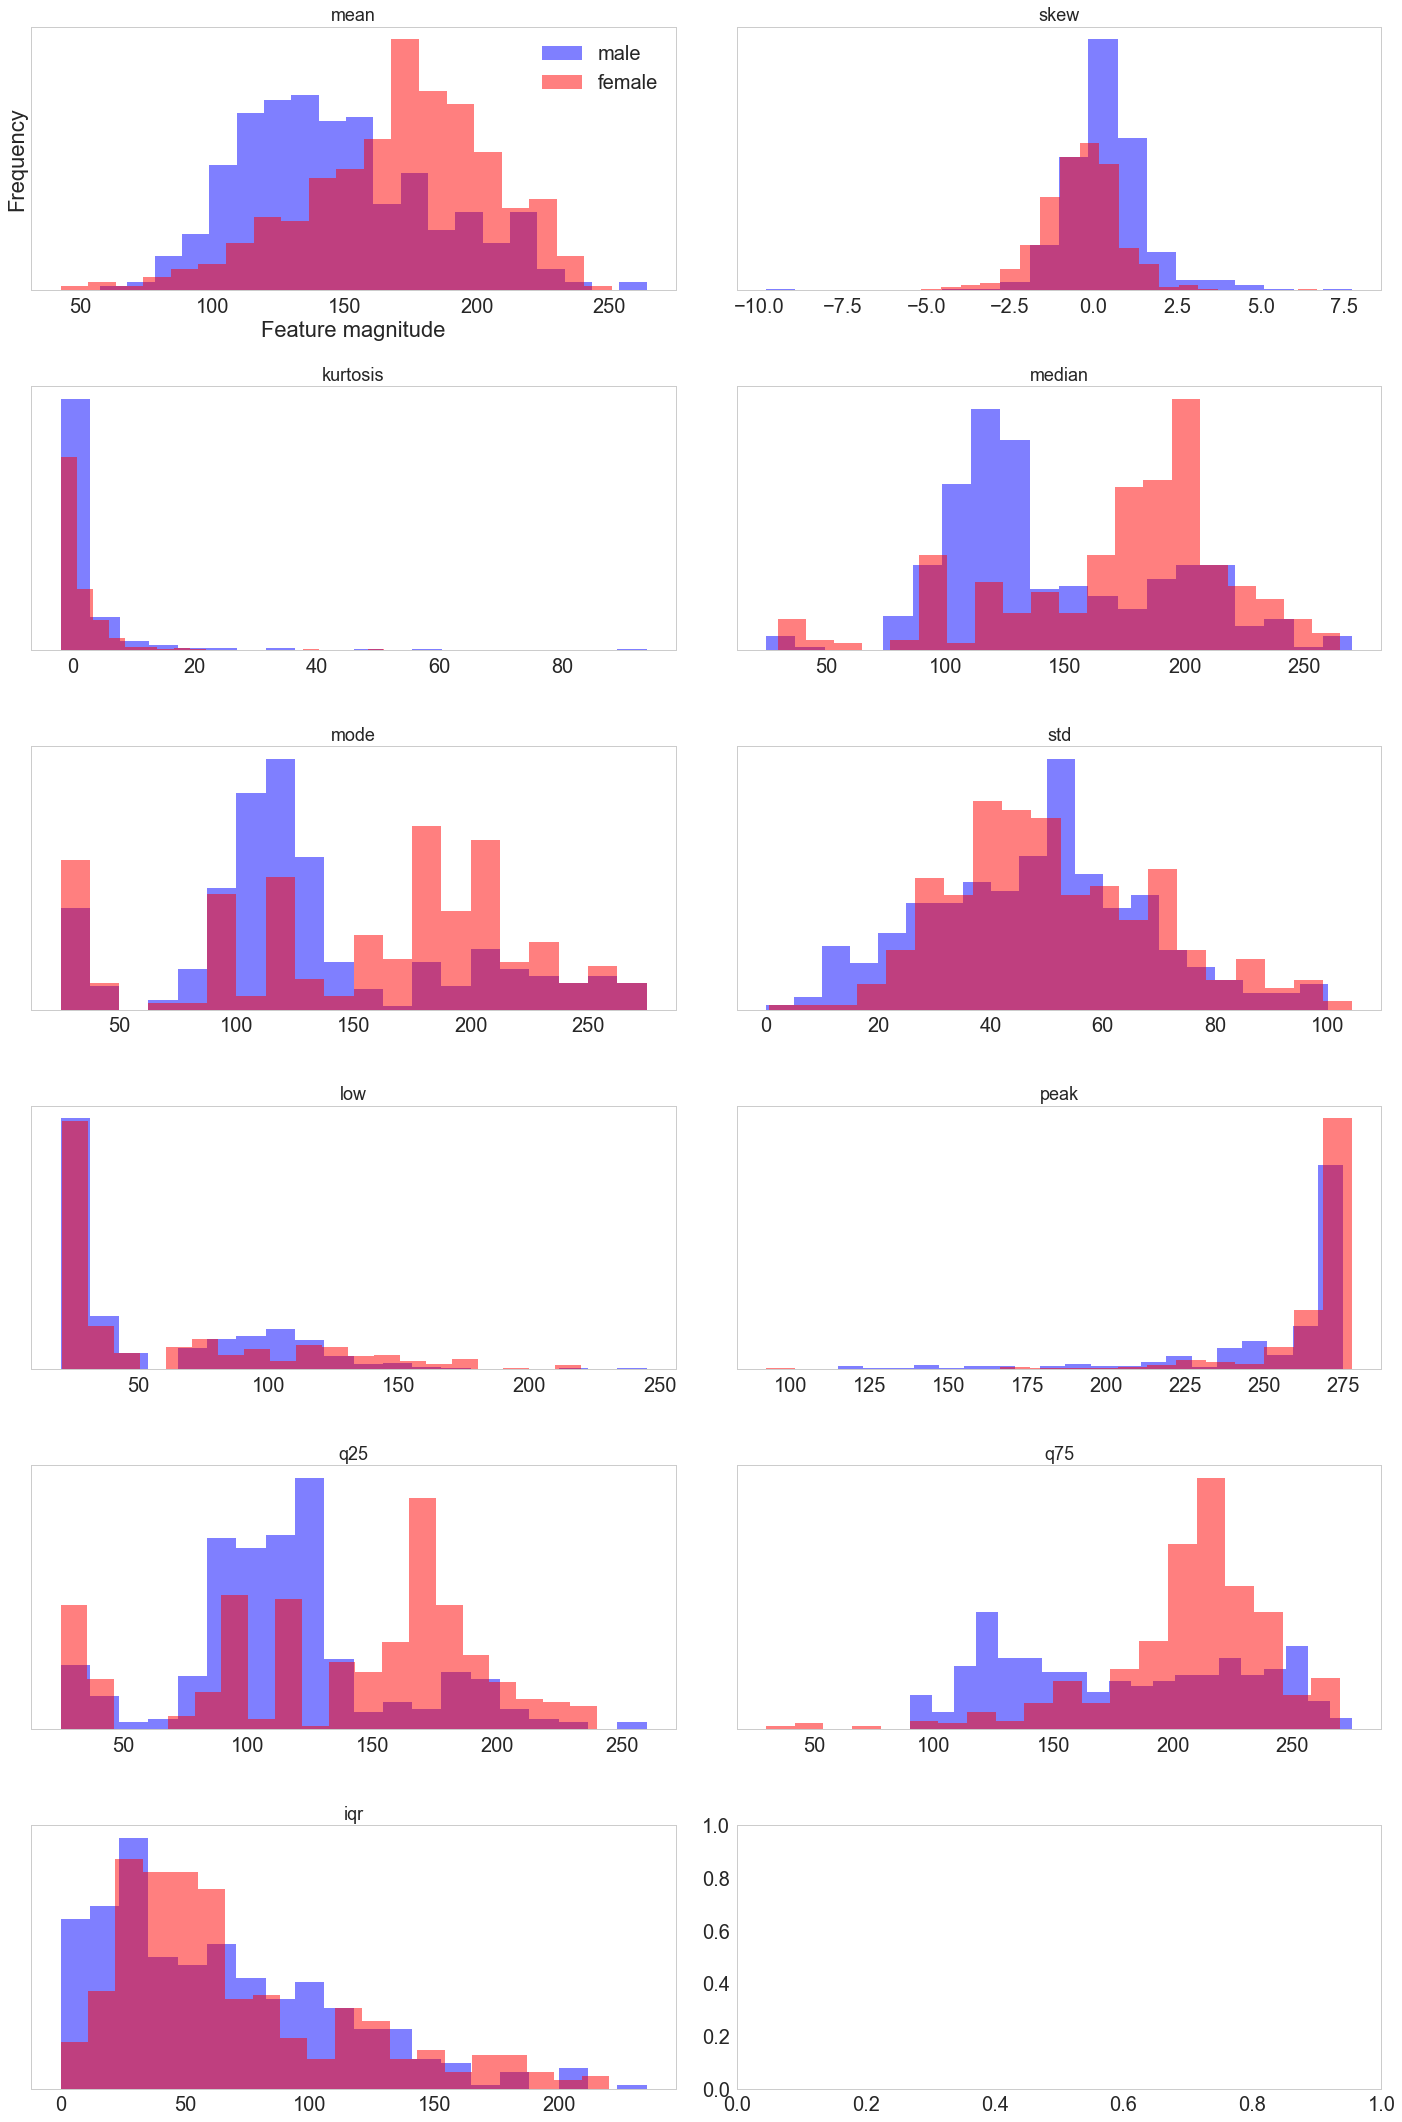

In [12]:
import warnings; warnings.simplefilter('ignore')
sb.set_style("whitegrid", {'axes.grid' : False})

female = mydata.loc[mydata.gender=='Female']
male = mydata.loc[mydata.gender=='Male']
#take a sample of the male population of equal size of the female (otherwise the frequencies will be much lower for female)
male_ = male.sample(len(female))

features = ['mean', 'skew', 'kurtosis', 'median', 'mode', 'std', 'low', 'peak', 'q25', 'q75', 'iqr']

#Plot the histograms
fig, axes = plt.subplots(6, 2, figsize=(20,30))

ax = axes.flatten() #ravel()

for i in range(len(features)):
    ax[i].hist(male_.ix[:,features[i]], bins=20, color='blue', alpha=.5)
    ax[i].hist(female.ix[:, features[i]], bins=20, color='red', alpha=.5)
    ax[i].set_title(features[i], fontsize=18)
    ax[i].set_yticks(())
    
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["male", "female"], loc="best")
fig.tight_layout()

plt.show()


### Modeling using different ML algorithms from sklearn

#### Try different ML algorithms. From Sklearn:

**Decision Trees (DTs)** are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

**Gradient Tree Boosting or Gradient Boosted Regression Trees (GBRT)** is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. Gradient Tree Boosting models are used in a variety of areas including Web search ranking and ecology.

**Random forests** : Each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features

**Support Vector Machine** C-Support Vector Classification. The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples. The multiclass support is handled according to a one-vs-one scheme.

**Neural network** MLPClassifier, MLP trains on two arrays: array X of size (n_samples, n_features), which holds the training samples represented as floating point feature vectors; and array y of size (n_samples,), which holds the target values (class labels) for the training samples

In [13]:
#Prepare data for modeling
mydata = mydata[mydata.gender != 'not_specified']
mydata.loc[:,'gender'][mydata['gender']=="Male"] = 0
mydata.loc[:,'gender'][mydata['gender']=="Female"] = 1

#split mydata into train and test
mydata_train, mydata_test = train_test_split(mydata, random_state=0, test_size=.2)

#Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler.fit(mydata_train.ix[:,features]) 
X_train = scaler.transform(mydata_train.ix[:,features])
X_test = scaler.transform(mydata_test.ix[:,features])
y_train = list(mydata_train['gender'].values)
y_test = list(mydata_test['gender'].values)

#Train decision tree model
tree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
print("\nDecision Tree")
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

#Train random forest model
forest = RandomForestClassifier(n_estimators=5, random_state=0).fit(X_train, y_train)
print("\nRandom Forests")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

#Train gradient boosting model
gbrt = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
print("\nGradient Boosting")
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

#Train support vector machine model
svm = SVC().fit(X_train, y_train)
print("\nSupport Vector Machine")
print("Accuracy on training set: {:.3f}".format(svm.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(svm.score(X_test, y_test)))

#Train neural network model
mlp = MLPClassifier(random_state=0).fit(X_train, y_train)
print("\nMultilayer Perceptron")
print("Accuracy on training set: {:.3f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test, y_test)))


Decision Tree
Accuracy on training set: 1.000
Accuracy on test set: 0.899

Random Forests
Accuracy on training set: 0.989
Accuracy on test set: 0.933

Gradient Boosting
Accuracy on training set: 0.958
Accuracy on test set: 0.937

Support Vector Machine
Accuracy on training set: 0.927
Accuracy on test set: 0.921

Multilayer Perceptron
Accuracy on training set: 0.937
Accuracy on test set: 0.933


In [20]:
def plot_feature_importances_mydata(model, c):
    n_features = len(features)
    plt.figure(1,figsize=(18,10))
    plt.bar(range(n_features), model.feature_importances_, align='center', color=c)
    plt.xticks(np.arange(n_features), features)
    plt.ylabel("Variable importance")
    plt.xlabel("Independent Variable")
    plt.title(model.__class__.__name__)
    plt.show()

### Assessment of feature importances
Methods that use ensembles of decision trees (Tree, Forest and Gradient Boosting) can also compute the relative importance of each attribute. 
These importance values can be used to inform a feature selection process.

The feature importance depends on how well a feature discriminates between the classes

The **std dev** seems to be in the top 3 most imporant features in the three tree-based models
Then **kurtosis** and **skewness** appear in the top 3 most important features for 2 out of the 3 classifiers

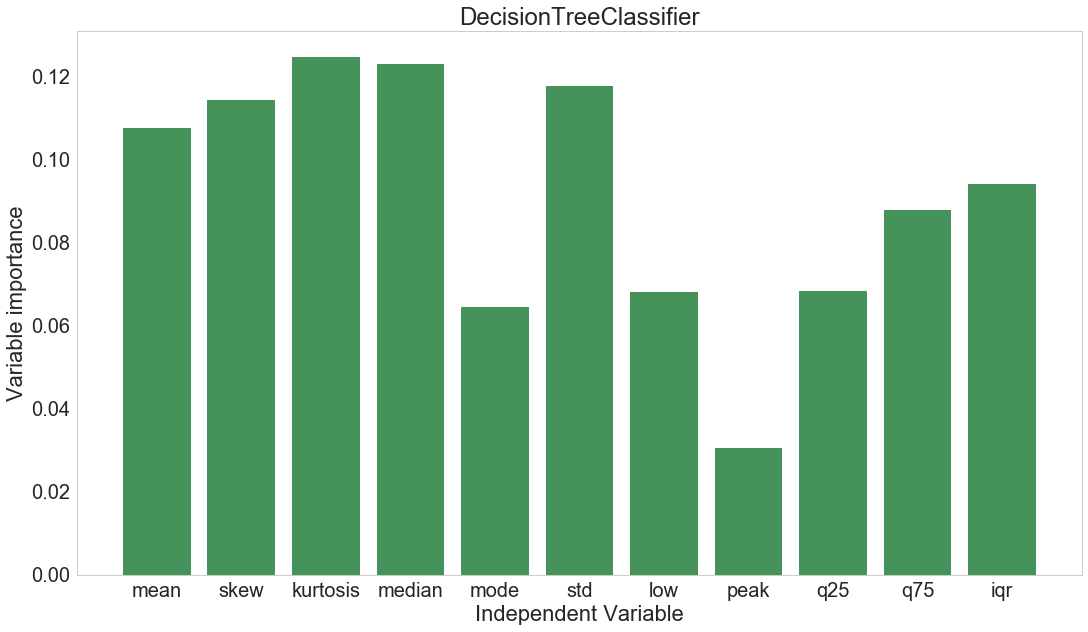

In [21]:
plot_feature_importances_mydata(tree,  '#45935B')

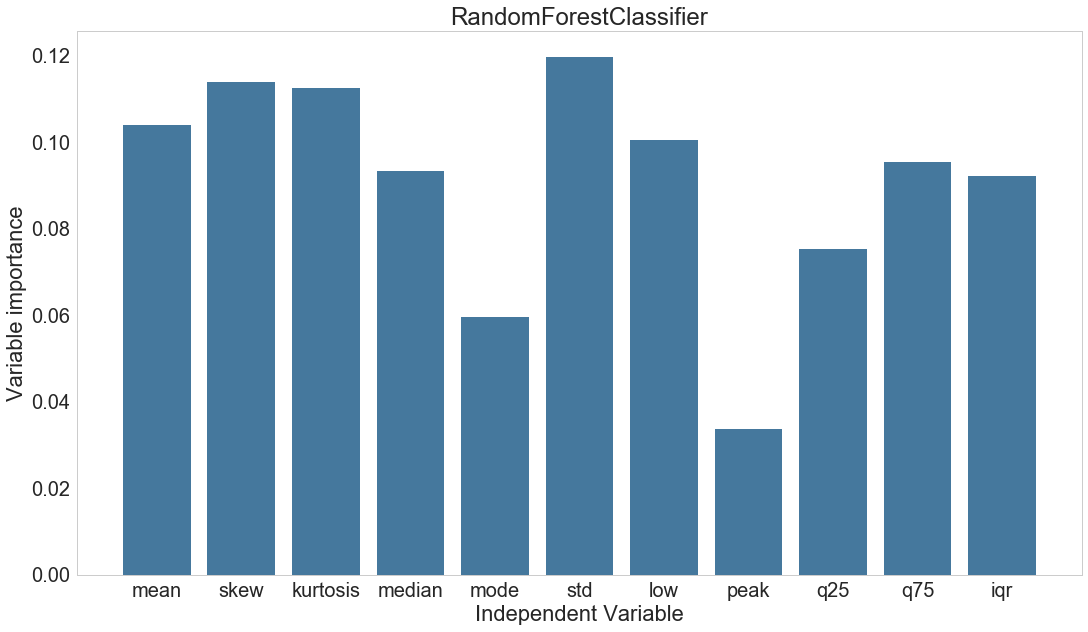

In [22]:
plot_feature_importances_mydata(forest, '#45789D')

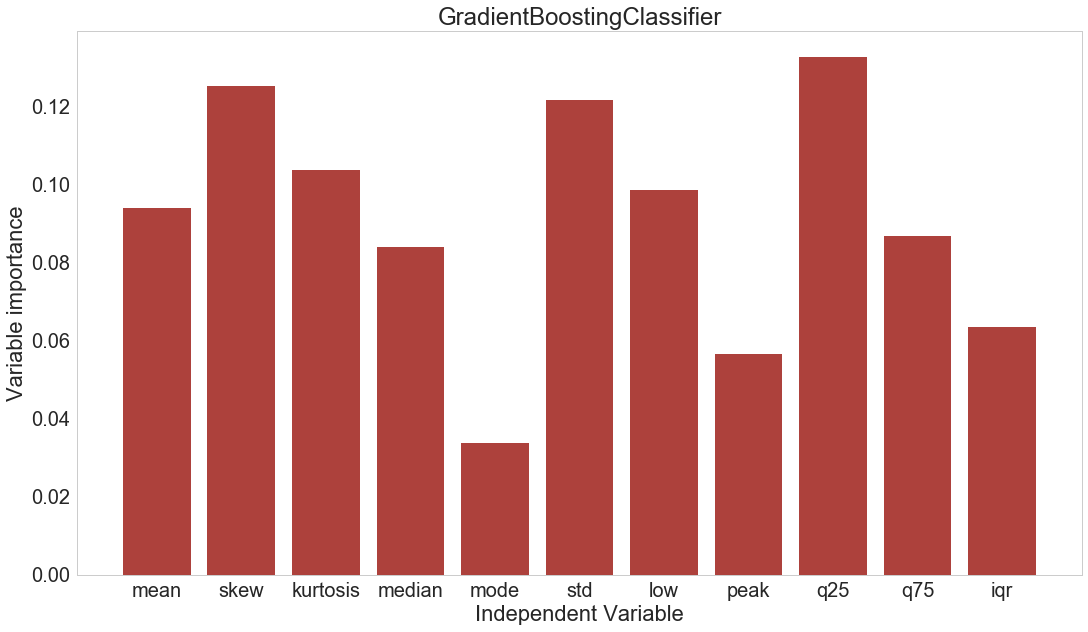

In [23]:
plot_feature_importances_mydata(gbrt, '#AD413C')

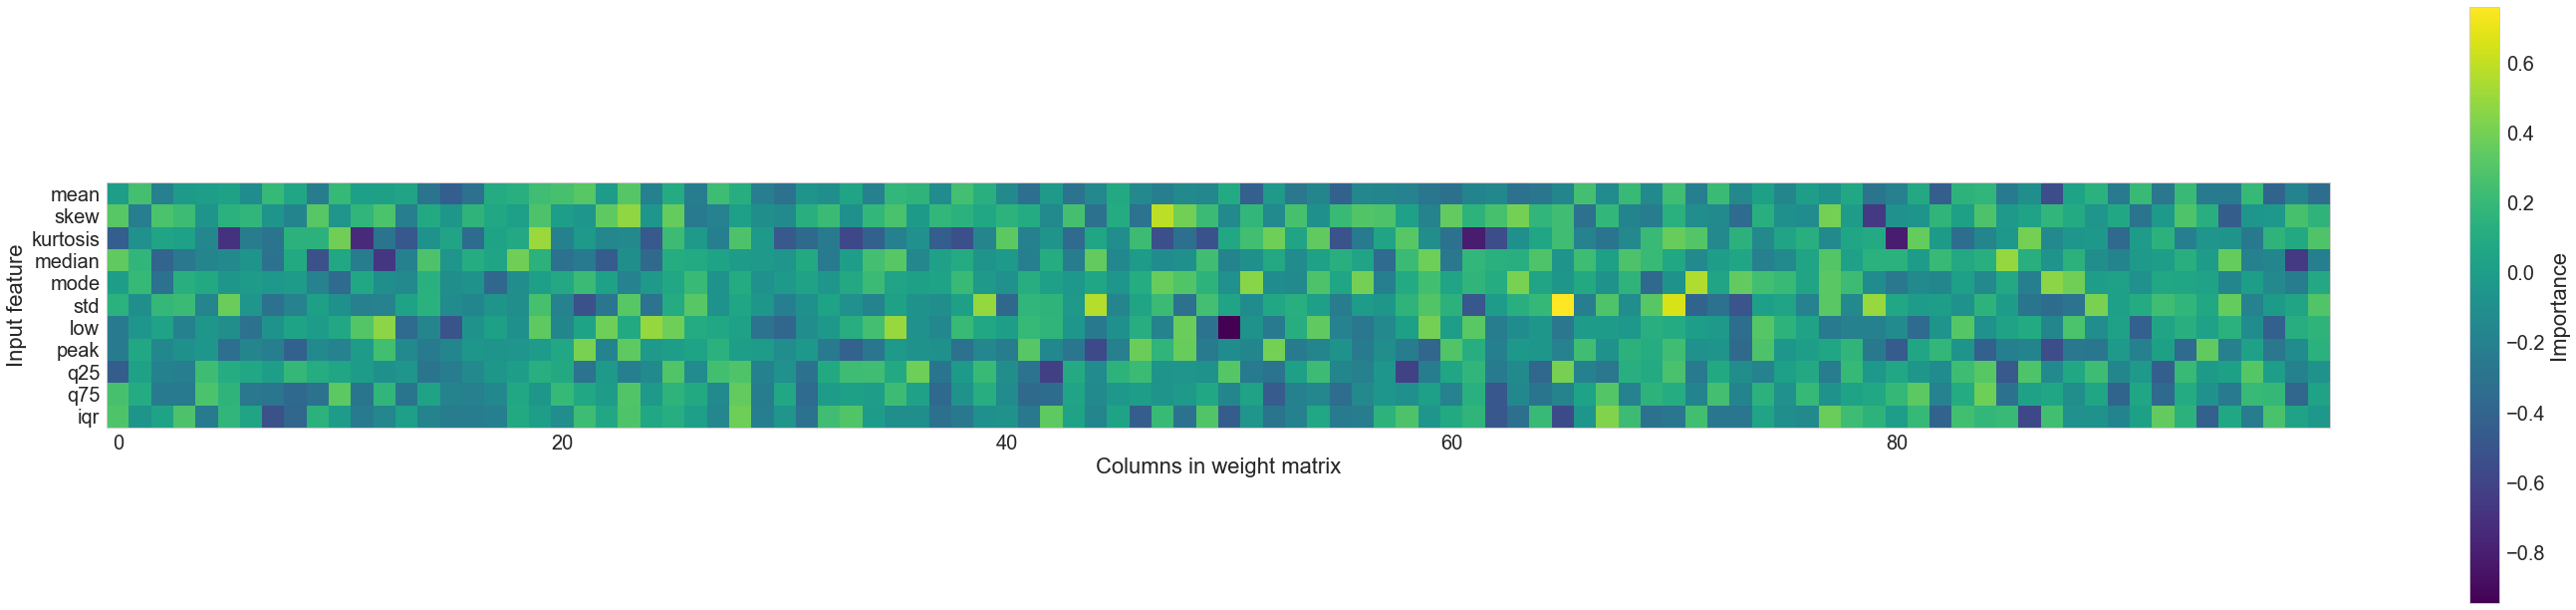

In [28]:
#Plot the heatmap on first layer weights for neural network
plt.figure(figsize=(50, len(features)))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(len(features)), features)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar().set_label('Importance')

plt.show()

### Discussion. Feature selection. Model performance and applicability

As stated above **std dev**, **kurtosis** and **skewness** seem to have the most discriminant power.
Some unexpected behaviour is the peaks at very low frequencies (< 50 Hz) that can be appreciated in **mode** and **median**. This might be the effect of the presence of noise in the audio recordings. Even if it was filtered, not all sources of noise were accounted for and a further analysis in this way would be interesting but falls beyond the scope of this project.

A further exploration on potential interesting features could also be assessed.  
Other features that were not considered here but could also have good discriminant power are: 
spectral flatness  
spectral entropy  
fundamental frequency  

On the other hand, the set of selected features seem to be enough for the tested models to achieve a good accuracy. The **Gradient Tree Boosting** gave the best accuracy followed closely by the **Random Forest** and the **Neural Network**

As for the applicability of the tested models, the analysis of this dataset was supervised and one might not always have access to the labels of the different categories. But they could be of great utility in different scenarios, like discerning music/speech or a correctly functioning machine/instrument from a faulty one.